## Task:

Susan has created a daily climatology of watershed discharges, based on monthly means. SEE:
https://github.com/SalishSeaCast/tools/blob/master/I_ForcingFiles/Rivers/SeasonalCyclesFromMonthlyMeans.ipynb

Daily files read into the model are currently in the form:
    
    "R201702DFraCElse_y2017m01d10.nc" 
stored in:
    
    /results/forcing/rivers
where the Fraser has a daily real-time value from the Hope gauge, and the rest of the rivers are the morison climatology. 

We need to create files of the above form, one file per day, except replacing the Morrison climatology with the interpolated climatology. Need to be v.v. careful with units, as m3/s units are not used in the model. 

    Rivers are treated like rain, added from above.  So kg of water/m2 /s where the m2 is horizontal area.  This we will call nf (nemo flux)
    So for m3/s first we convert from mass to volume
    nf / rho (fresh water so 1000 kg/m3)  so now we have m/s
    Then multiply by the area of the grid cell
     nf  / rho * e1t(i,j) *e2t(i,j)

The steps are as follows:

    1) Open the river climatology file from 
        rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc
    2) use the river properties dictionary, the 'prop' key to distribute the climatology among individual rivers, still in m3/s, and save in a new dictionary -
    3) translate from m3/s to kg/m2/s, save that into the new dictionary
             ie eg river "nooksack" will have 365 numbers, in kg/m2/s 
    4) create new daily files and populate them with the numbers from 3, using the i and j values found in the river properties dictionary. These daily files are of a similar type as "R201702DFraCElse_y2017m01d10.nc" 

In [39]:
%reset
import netCDF4 as nc
import numpy as np
import arrow
import matplotlib.pyplot as plt

import sys
sys.path.append('/data/tjarniko/MEOPAR/tools/SalishSeaTools/salishsea_tools/')
#import mocsy
import river_201702 as rv
import river_downbyone2 as rv2

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### Trying to understand inconsistency between how rivers are seen in the different grids - using downbyone grid for the R201702DFraCElse_y2017m01d10.nc and other files...

In [40]:
print('river is Oyster, properties')
print('rivers201702')
print(rv.prop_dict['evi_n']['Oyster'])
print('riversdownbyone')
print(rv2.prop_dict['evi_n']['Oyster'])
print('note j and i are backwards')

print('output from j = 706, i = 123 from rivers/rivers_month_201702.nc')
rivdat = nc.Dataset('/data/tjarniko/MEOPAR/rivers/rivers_month_201702.nc')
t_runoff = rivdat.variables['rorunoff'][8,706,123]
print(t_runoff)
print('output from j = 706, i = 123 from results/forcing/rivers/RLonFraCElse_y2017m08d07.nc')
sample_river_file = \
nc.Dataset('/results/forcing/rivers/RLonFraCElse_y2017m08d07.nc')
print(sample_river_file['rorunoff'][0,706,123])
print('output from wider area around this point')
print(sample_river_file['rorunoff'][0,706-2:706+2,123-2:123+2])
print('output from j = 705, i = 122 (so off by 1)')
print(sample_river_file['rorunoff'][0,705,122])
print('so, populate using the downbyone grid')

river is Oyster, properties
rivers201702
{'prop': 0.03738799052425584, 'i': 706, 'j': 123, 'di': 1, 'dj': 1, 'depth': 1}
riversdownbyone
{'prop': 0.03738799052425584, 'i': 705, 'j': 122, 'di': 1, 'dj': 1, 'depth': 3}
note j and i are backwards
output from j = 706, i = 123 from rivers/rivers_month_201702.nc
0.033809192
output from j = 706, i = 123 from results/forcing/rivers/RLonFraCElse_y2017m08d07.nc
0.0
output from wider area around this point
[[0.         0.         0.         0.        ]
 [0.         0.03536774 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
output from j = 705, i = 122 (so off by 1)
0.035367742
so, populate using the downbyone grid


In [41]:
sample_river_file = \
nc.Dataset('/results/forcing/rivers/RLonFraCElse_y2017m08d07.nc')

#print(sample_river_file)

climatology_file = \
nc.Dataset('/data/tjarniko/MEOPAR/rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc')
#print(climatology_file['fraser'][300])

watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

In [42]:
import copy
clim_dict = copy.deepcopy(rv.prop_dict)
grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

for w in watersheds:
    interp_clim = climatology_file[w][:]

    print(w)
    #print(interp_clim)
    rivers = (rv.prop_dict[w].keys())
    for r in rivers:
        #print(r)
        prop_wshed = rv.prop_dict[w][r]['prop']
        clim_dict[w][r]['interp_clim'] = prop_wshed * interp_clim
        river_i = rv.prop_dict[w][r]['j']
        river_j = rv.prop_dict[w][r]['i']
        river_dj = rv.prop_dict[w][r]['di']
        river_di = rv.prop_dict[w][r]['dj']
        area = grid['e1t'][0,river_j,river_i]*grid['e2t'][0,river_j,river_i]
        clim_dict[w][r]['interp_clim_modunits'] = prop_wshed * interp_clim / area * 1000
       # if ((river_dj > 1) | (river_di > 1)):
       #     print(r)
       #     print(rv2.prop_dict[w][r])
#runoff_m3 = (year_runoff / 1000) * t_area
#runoff in model units = runoff_m3 / t_area * 1000 



howe
jdf
puget
skagit
fraser
evi_n
jervis
toba
bute
evi_s


In [43]:
# print(rv2.prop_dict['howe']['Squamish']['i'])
# #{'prop': 0.9, 'i': 532, 'j': 385, 'di': 1, 'dj': 2, 'depth': 3}
# sample_river_file = \
# nc.Dataset('/results/forcing/rivers/RLonFraCElse_y2017m08d07.nc')

# print(sample_river_file['rorunoff'][0,532-2:532+2,385-2:385+2])

# print(clim_dict['howe']['Squamish']['interp_clim_modunits'][219])


# print(rv2.prop_dict['evi_n']['Oyster'])
# print(sample_river_file['rorunoff'][0,706-1:706+1,123-1:123+1])
# print(clim_dict['evi_n']['Oyster']['interp_clim_modunits'][218])

#### checking the Squamish river interpolated result against a daily file

In [44]:
# print(rv2.prop_dict['howe'])


# riv_i = clim_dict['howe']['Squamish']['i']
# riv_j = clim_dict['howe']['Squamish']['j']
# riv_di = clim_dict['howe']['Squamish']['di']
# riv_dj = clim_dict['howe']['Squamish']['dj']
# print(riv_i)
# #print(sample_river_file['rorunoff'][0,532-2:532+2,385-2:385+2])
# print(sample_river_file['rorunoff'][0,riv_i:riv_i+riv_di,riv_j:riv_j+riv_dj])
# print(clim_dict['howe']['Squamish']['interp_clim_modunits'][219])

# print(rivdat.variables['rorunoff'][8,534,384:386])


#### checking the homathko river interpolated result against a daily file

In [45]:
# print(rv2.prop_dict['bute'])


# riv_i = clim_dict['bute']['Homathko']['i']
# riv_j = clim_dict['bute']['Homathko']['j']
# riv_di = clim_dict['bute']['Homathko']['di']
# riv_dj = clim_dict['bute']['Homathko']['dj']
# print(riv_i)
# #print(sample_river_file['rorunoff'][0,532-2:532+2,385-2:385+2])
# print(sample_river_file['rorunoff'][0,riv_i:riv_i+riv_di,riv_j:riv_j+riv_dj])
# print(clim_dict['bute']['Homathko']['interp_clim_modunits'][219])



### 

#### THIS CODE CALCULATES THE APPROPRIATE DAILY CLIMATOLOGY FOR EACH RIVER, THEN (IF verbose == true) COMPARES IT FOR A SAMPLE DAY WITH THE MONTHLY CLIMATOLOGY FILE

In [46]:
print(rv.prop_dict)

{'howe': {'Squamish': {'prop': 0.9, 'i': 534, 'j': 384, 'di': 1, 'dj': 2, 'depth': 2}, 'Burrard': {'prop': 0.1, 'i': 457, 'j': 343, 'di': 3, 'dj': 1, 'depth': 3}}, 'jdf': {'SanJuan': {'prop': 0.165, 'i': 401, 'j': 63, 'di': 1, 'dj': 1, 'depth': 1}, 'Gordon': {'prop': 0.07, 'i': 404, 'j': 64, 'di': 1, 'dj': 1, 'depth': 1}, 'Loss': {'prop': 0.025, 'i': 376, 'j': 72, 'di': 1, 'dj': 1, 'depth': 1}, 'Jordan': {'prop': 0.025, 'i': 349, 'j': 97, 'di': 1, 'dj': 1, 'depth': 1}, 'Muir': {'prop': 0.025, 'i': 327, 'j': 120, 'di': 1, 'dj': 1, 'depth': 1}, 'Tugwell': {'prop': 0.025, 'i': 325, 'j': 121, 'di': 1, 'dj': 1, 'depth': 1}, 'Sooke': {'prop': 0.165, 'i': 316, 'j': 144, 'di': 1, 'dj': 1, 'depth': 1}, 'Elwha': {'prop': 0.15, 'i': 261, 'j': 134, 'di': 1, 'dj': 1, 'depth': 1}, 'Tumwater': {'prop': 0.003, 'i': 248, 'j': 151, 'di': 1, 'dj': 1, 'depth': 1}, 'Valley': {'prop': 0.003, 'i': 247, 'j': 152, 'di': 1, 'dj': 1, 'depth': 1}, 'Ennis': {'prop': 0.006, 'i': 244, 'j': 156, 'di': 1, 'dj': 1, 'de

In [47]:
#print(np.shape(sample_river_file['rorunoff'][0,:,:]))
#print(np.max((sample_river_file['rorunoff'][0,:,:])))
verbose = False
frasers = ['Fraser']
for w in watersheds:
    interp_clim = climatology_file[w][:]
    #print('')
    print(w)
    #print(interp_clim)
    rivers = (rv.prop_dict[w].keys())
    for r in rivers:
#        if (r not in frasers):

        prop_wshed = rv.prop_dict[w][r]['prop']
        clim_dict[w][r]['interp_clim'] = prop_wshed * interp_clim
        river_i = rv.prop_dict[w][r]['j']
        river_di = rv.prop_dict[w][r]['dj']

        river_j = rv.prop_dict[w][r]['i']
        river_dj = rv.prop_dict[w][r]['di']
        area = grid['e1t'][0,river_j,river_i]*grid['e2t'][0,river_j,river_i]
        clim_dict[w][r]['interp_clim_modunits'] = prop_wshed * interp_clim / area * 1000
        size_inflow = river_di * river_dj
        if verbose == True:
            print(r)
            print(size_inflow)
            print('sample river file runoff')
            print(sample_river_file['rorunoff'][0,river_j:river_j+river_dj,river_i:river_i+river_di])
            print(sample_river_file['rorunoff'][0,river_j-1:river_j+river_dj+1,river_i-1:river_i+river_di+1])
            print('daily climatology result: ' + str(clim_dict[w][r]['interp_clim_modunits'][219]))
            print('')
        

howe
jdf
puget
skagit
fraser
evi_n
jervis
toba
bute
evi_s


In [48]:
start ='2017-01-01'
end ='2017-12-31'
frasers = ['Fraser']
verbose = False
start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)


for date in range(0,len(arrow_array)):
    print(date)
    #get appropriate date and open old river file
    tdate = arrow_array[date][0]
    y = tdate.format('YYYY')
    m = tdate.format('MM')
    d = tdate.format('DD')
    tday = f"y{y}m{m}d{d}"
    print(tday)
    trivfile = f"/results/forcing/rivers/R201702DFraCElse_y{y}m{m}d{d}.nc"
    triv = nc.Dataset(trivfile)
    #print(triv)
    
    ## open rorunoff file and copy it
    rorunoff = triv['rorunoff'][:]
    if verbose == True:
        print(np.shape(rorunoff))
    new_rorunoff = np.copy(rorunoff)
    
    #populate rorunoff with new climatology for ever river except the frasers
    for w in watersheds:
        #interp_clim = climatology_file[w][:]
        if verbose == True:
            print('')
            print(w)
        #print(interp_clim)
        rivers = (rv.prop_dict[w].keys())
        for r in rivers:
             if (r not in frasers):

                #prop_wshed = rv2.prop_dict[w][r]['prop']
                #clim_dict[w][r]['interp_clim'] = prop_wshed * interp_clim
                river_i = rv.prop_dict[w][r]['j']
                river_di = rv.prop_dict[w][r]['dj']

                river_j = rv.prop_dict[w][r]['i']
                river_dj = rv.prop_dict[w][r]['di']
                #area = grid['e1t'][0,river_j,river_i]*grid['e2t'][0,river_j,river_i]
                #clim_dict[w][r]['interp_clim_modunits'] = prop_wshed * interp_clim / area * 1000
                todays_inflow = clim_dict[w][r]['interp_clim_modunits'][date]
                size_inflow = river_di * river_dj
                populate_inflow = todays_inflow/size_inflow
                new_rorunoff[0,river_j:river_j+river_dj,river_i:river_i+river_di] = populate_inflow

                if verbose == True:
                    print(r)
                    print(size_inflow)
                    print('daily climatology result: ' + str(clim_dict[w][r]['interp_clim_modunits'][date]))
                    print('')
    

    
    ### code to copy the new rivers file into its own .nc
    dsin = triv
    newrivfile = f"./daily_R201702/R201702DFraDailyElse_y{y}m{m}d{d}.nc"
    ncname = newrivfile
    print(newrivfile)
    
    dsout = nc.Dataset(ncname, "w", format="NETCDF4")
    #Copy dimensions
    for dname, the_dim in dsin.dimensions.items():
        #print(dname)
        #print(len(the_dim))
        dsout.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)
    # Copy variables
    for v_name, varin in dsin.variables.items():
        #print(v_name)
        outVar = dsout.createVariable(v_name, varin.datatype, varin.dimensions)
        #print(varin.datatype)
        outVar.setncatts({k: varin.getncattr(k) for k in varin.ncattrs()})
        outVar[:] = varin[:]
    dsout['rorunoff'][:] = new_rorunoff
    dsout.close()

0
y2017m01d01
./daily_R201702/R201702DFraDailyElse_y2017m01d01.nc
1
y2017m01d02
./daily_R201702/R201702DFraDailyElse_y2017m01d02.nc
2
y2017m01d03
./daily_R201702/R201702DFraDailyElse_y2017m01d03.nc
3
y2017m01d04
./daily_R201702/R201702DFraDailyElse_y2017m01d04.nc
4
y2017m01d05
./daily_R201702/R201702DFraDailyElse_y2017m01d05.nc
5
y2017m01d06
./daily_R201702/R201702DFraDailyElse_y2017m01d06.nc
6
y2017m01d07
./daily_R201702/R201702DFraDailyElse_y2017m01d07.nc
7
y2017m01d08
./daily_R201702/R201702DFraDailyElse_y2017m01d08.nc
8
y2017m01d09
./daily_R201702/R201702DFraDailyElse_y2017m01d09.nc
9
y2017m01d10
./daily_R201702/R201702DFraDailyElse_y2017m01d10.nc
10
y2017m01d11
./daily_R201702/R201702DFraDailyElse_y2017m01d11.nc
11
y2017m01d12
./daily_R201702/R201702DFraDailyElse_y2017m01d12.nc
12
y2017m01d13
./daily_R201702/R201702DFraDailyElse_y2017m01d13.nc
13
y2017m01d14
./daily_R201702/R201702DFraDailyElse_y2017m01d14.nc
14
y2017m01d15
./daily_R201702/R201702DFraDailyElse_y2017m01d15.nc
15
y2

124
y2017m05d05
./daily_R201702/R201702DFraDailyElse_y2017m05d05.nc
125
y2017m05d06
./daily_R201702/R201702DFraDailyElse_y2017m05d06.nc
126
y2017m05d07
./daily_R201702/R201702DFraDailyElse_y2017m05d07.nc
127
y2017m05d08
./daily_R201702/R201702DFraDailyElse_y2017m05d08.nc
128
y2017m05d09
./daily_R201702/R201702DFraDailyElse_y2017m05d09.nc
129
y2017m05d10
./daily_R201702/R201702DFraDailyElse_y2017m05d10.nc
130
y2017m05d11
./daily_R201702/R201702DFraDailyElse_y2017m05d11.nc
131
y2017m05d12
./daily_R201702/R201702DFraDailyElse_y2017m05d12.nc
132
y2017m05d13
./daily_R201702/R201702DFraDailyElse_y2017m05d13.nc
133
y2017m05d14
./daily_R201702/R201702DFraDailyElse_y2017m05d14.nc
134
y2017m05d15
./daily_R201702/R201702DFraDailyElse_y2017m05d15.nc
135
y2017m05d16
./daily_R201702/R201702DFraDailyElse_y2017m05d16.nc
136
y2017m05d17
./daily_R201702/R201702DFraDailyElse_y2017m05d17.nc
137
y2017m05d18
./daily_R201702/R201702DFraDailyElse_y2017m05d18.nc
138
y2017m05d19
./daily_R201702/R201702DFraDaily

./daily_R201702/R201702DFraDailyElse_y2017m09d06.nc
249
y2017m09d07
./daily_R201702/R201702DFraDailyElse_y2017m09d07.nc
250
y2017m09d08
./daily_R201702/R201702DFraDailyElse_y2017m09d08.nc
251
y2017m09d09
./daily_R201702/R201702DFraDailyElse_y2017m09d09.nc
252
y2017m09d10
./daily_R201702/R201702DFraDailyElse_y2017m09d10.nc
253
y2017m09d11
./daily_R201702/R201702DFraDailyElse_y2017m09d11.nc
254
y2017m09d12
./daily_R201702/R201702DFraDailyElse_y2017m09d12.nc
255
y2017m09d13
./daily_R201702/R201702DFraDailyElse_y2017m09d13.nc
256
y2017m09d14
./daily_R201702/R201702DFraDailyElse_y2017m09d14.nc
257
y2017m09d15
./daily_R201702/R201702DFraDailyElse_y2017m09d15.nc
258
y2017m09d16
./daily_R201702/R201702DFraDailyElse_y2017m09d16.nc
259
y2017m09d17
./daily_R201702/R201702DFraDailyElse_y2017m09d17.nc
260
y2017m09d18
./daily_R201702/R201702DFraDailyElse_y2017m09d18.nc
261
y2017m09d19
./daily_R201702/R201702DFraDailyElse_y2017m09d19.nc
262
y2017m09d20
./daily_R201702/R201702DFraDailyElse_y2017m09d20

### Check that the river daily files are populated exactly where the old ones were

In [49]:
new_rivfile = nc.Dataset(f"./daily_R201702/R201702DFraDailyElse_y{y}m{m}d{d}.nc")
old_rivfile = nc.Dataset(f"/results/forcing/rivers/R201702DFraCElse_y{y}m{m}d{d}.nc")

new_runoff = new_rivfile['rorunoff'][:]
old_runoff = old_rivfile['rorunoff'][:]

populated_new = np.where(new_runoff != 0)
print(np.shape(populated_new))

populated_old = np.where(old_runoff != 0)
print(np.shape(populated_old))

pn = np.array(populated_new)
po = np.array(populated_old)
print(pn == po)

# comparison = populated_new == populated_old
# equal_arrays = comparison.all()
# print(equal_arrays)

# an_array = np.array([[1,2],[3,4]])
# another_array = np.array([[1,2],[3,4]])

# comparison = populated_old == another_array
# equal_arrays = comparison.all()
# print(equal_arrays)

# def cmpT(t1, t2): 
#   return sorted(t1) == sorted(t2)

# cmpT(populated_old,populated_new)

(3, 182)
(3, 182)
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True 

In [50]:
type(populated_old)

tuple

In [51]:
def compare_hydrographs_for_a_given_river(wshed, river):
    
    w = wshed
    r = river
    
    hydro_old = np.zeros(365)
    hydro_new = np.zeros(365)
    
    river_i = rv.prop_dict[w][r]['j']
    river_di = rv.prop_dict[w][r]['dj']
    river_j = rv.prop_dict[w][r]['i']
    river_dj = rv.prop_dict[w][r]['di']

    start ='2017-01-01'
    end ='2017-12-31'
    
    verbose = False
    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)
        
    for date in range(0,len(arrow_array)):
        #print(date)
        #get appropriate date and open old river file
        tdate = arrow_array[date][0]
        y = tdate.format('YYYY')
        m = tdate.format('MM')
        d = tdate.format('DD')
        tday = f"y{y}m{m}d{d}"
        #print(tday)
        trivfile = f"/results/forcing/rivers/R201702DFraCElse_y{y}m{m}d{d}.nc"
        triv = nc.Dataset(trivfile)
        newrivfile = f"./daily_R201702//R201702DFraDailyElse_y{y}m{m}d{d}.nc"
        newriv = nc.Dataset(newrivfile)
        
        hydro_old[date] = np.sum(triv['rorunoff'][0,river_j:river_j+river_dj,river_i:river_i+river_di])
        hydro_new[date] = np.sum(newriv['rorunoff'][0,river_j:river_j+river_dj,river_i:river_i+river_di])
    
    return hydro_old, hydro_new

In [52]:
hydro_old_Squamish, hydro_new_Squamish = \
compare_hydrographs_for_a_given_river('howe', 'Squamish')
hydro_old_Homathko, hydro_new_Homathko = \
compare_hydrographs_for_a_given_river('bute', 'Homathko')
hydro_old_Powell, hydro_new_Powell = \
compare_hydrographs_for_a_given_river('jervis', 'Powell')
hydro_old_Toba, hydro_new_Toba = \
compare_hydrographs_for_a_given_river('toba', 'Toba')
hydro_old_Englishman, hydro_new_Englishman = \
compare_hydrographs_for_a_given_river('evi_s', 'Englishman')
hydro_old_SanJuan, hydro_new_SanJuan = \
compare_hydrographs_for_a_given_river('jdf', 'SanJuan')
hydro_old_Fraser, hydro_new_Fraser = \
compare_hydrographs_for_a_given_river('fraser', 'Fraser')

In [53]:
np.shape(hydro_old_Squamish)

(365,)

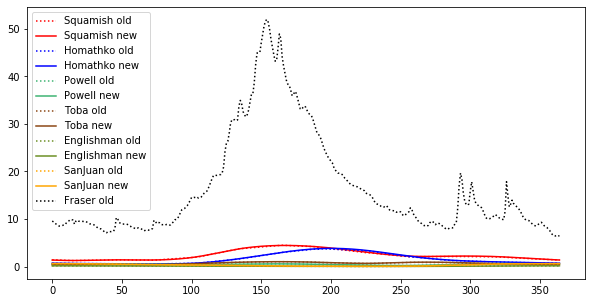

In [58]:
hydro_old_Squamish[364]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(np.arange(0,365,1),hydro_old_Squamish, \
        color = 'r', linestyle = ':',label = 'Squamish old')
ax.plot(np.arange(0,365,1),hydro_new_Squamish, \
        color = 'r', linestyle = '-',label = 'Squamish new')
ax.plot(np.arange(0,365,1),hydro_old_Homathko, \
        color = 'b', linestyle = ':',label = 'Homathko old')
ax.plot(np.arange(0,365,1),hydro_new_Homathko, \
        color = 'b', linestyle = '-',label = 'Homathko new')
ax.plot(np.arange(0,365,1),hydro_old_Powell, \
        color = 'mediumseagreen', linestyle = ':',label = 'Powell old')
ax.plot(np.arange(0,365,1),hydro_new_Powell, \
        color = 'mediumseagreen', linestyle = '-',label = 'Powell new')
ax.plot(np.arange(0,365,1),hydro_old_Toba, \
        color = 'saddlebrown', linestyle = ':',label = 'Toba old')
ax.plot(np.arange(0,365,1),hydro_new_Toba, \
        color = 'saddlebrown', linestyle = '-',label = 'Toba new')
ax.plot(np.arange(0,365,1),hydro_old_Englishman, \
        color = 'olivedrab', linestyle = ':',label = 'Englishman old')
ax.plot(np.arange(0,365,1),hydro_new_Englishman, \
        color = 'olivedrab', linestyle = '-',label = 'Englishman new')
ax.plot(np.arange(0,365,1),hydro_old_SanJuan, \
        color = 'orange', linestyle = ':',label = 'SanJuan old')
ax.plot(np.arange(0,365,1),hydro_new_SanJuan, \
        color = 'orange', linestyle = '-',label = 'SanJuan new')

ax.legend()

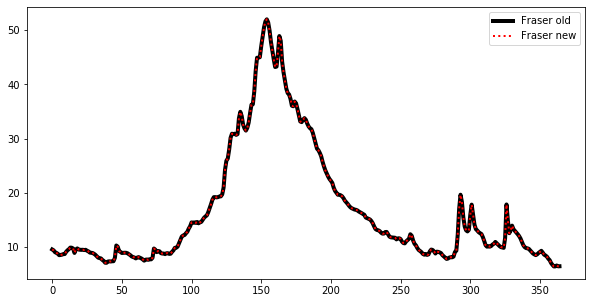

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.arange(0,365,1),hydro_old_Fraser, \
        color = 'k', linestyle = '-',label = 'Fraser old',linewidth = 4)
ax.plot(np.arange(0,365,1),hydro_new_Fraser, \
        color = 'red', linestyle = ':',label = 'Fraser new', linewidth = 2)
ax.legend()

In [56]:
rv.prop_dict['jervis']

{'SkwawkaHunaechin': {'prop': 0.05,
  'i': 692,
  'j': 332,
  'di': 1,
  'dj': 1,
  'depth': 1},
 'Loquilts': {'prop': 0.01, 'i': 674, 'j': 347, 'di': 1, 'dj': 1, 'depth': 1},
 'Potato': {'prop': 0.01, 'i': 666, 'j': 349, 'di': 1, 'dj': 1, 'depth': 1},
 'Deserted': {'prop': 0.025, 'i': 653, 'j': 353, 'di': 1, 'dj': 1, 'depth': 1},
 'Stakawus': {'prop': 0.01, 'i': 651, 'j': 346, 'di': 1, 'dj': 1, 'depth': 1},
 'Crabapple': {'prop': 0.01, 'i': 665, 'j': 342, 'di': 1, 'dj': 1, 'depth': 1},
 'Osgood': {'prop': 0.01, 'i': 652, 'j': 323, 'di': 1, 'dj': 1, 'depth': 1},
 'Lausmann': {'prop': 0.0075,
  'i': 690,
  'j': 332,
  'di': 1,
  'dj': 1,
  'depth': 1},
 'Slane': {'prop': 0.0075, 'i': 687, 'j': 331, 'di': 1, 'dj': 1, 'depth': 1},
 'Smanit': {'prop': 0.01, 'i': 681, 'j': 334, 'di': 1, 'dj': 1, 'depth': 1},
 'Glacial': {'prop': 0.0125, 'i': 649, 'j': 310, 'di': 1, 'dj': 1, 'depth': 1},
 'Seshal': {'prop': 0.0125, 'i': 652, 'j': 318, 'di': 1, 'dj': 1, 'depth': 1},
 'Brittain': {'prop': 0.02